In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer


Mounted at /content/drive


## 전처리

In [26]:
data_folder = '/content/drive/MyDrive/2months_data/2months_data'
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]

def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")

valid_dataframes = []
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:
          valid_dataframes.append(df)
    except ValueError as e:
        print(e)

if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()
combined_data.columns=["Creation date", "load factor", "Set Pressure", "Boiler Pressure",
                      "Blower Inverter Output", "Blower Input", "Water Supply Pump",
                      "Water Supply Pump Input", "Gas Damper", "Gas Damper Input",
                      "Air Damper", "Air Damper Input", "Recirculation Damper",
                      "Recirculation External Damper", "Recirculation Damper Input",
                      "Recirculation External Damper Input", "Water Supply Level",
                      "Boiler Temperature", "Exhaust Gas Temperature 1",
                      "Exhaust Gas Temperature 2", "Exhaust Gas Temperature 3",
                      "Exhaust Recirculation Temperature", "Economizer Temperature 1",
                      "Economizer Temperature 2", "Burner Temperature", "Exhaust Gas NOx",
                      "Exhaust Gas O2", "Recirculation O2", "Recirculation NOx",
                      "Water Supply Amount (Cumulative Flow)",
                      "Water Supply Amount (Instantaneous Flow)",
                      "Fuel Amount (Cumulative Flow)", "Fuel Amount (Instantaneous Flow)",
                      "Efficiency (Instantaneous)", "Power Consumption", "Vibration Sensor 1",
                      "Vibration Sensor 2", "Operating Time", "Normal Operation Probability",
                      "Blower Failure Probability", "Air Damper Failure Probability",
                      "Gas Damper Failure Probability", "Probability Update Time",
                      "Instantaneous Steam Amount", "Input-Output Efficiency",
                      "Heat Loss Efficiency", "Efficiency (input/output method-steam)"]

combined_data = combined_data.reset_index()
combined_data = combined_data.shift(periods=1, axis=1)
combined_data = combined_data.drop(columns=['index'])

combined_data = combined_data.drop(columns=[
    "Creation date","Power Consumption","Vibration Sensor 1","Vibration Sensor 2","Operating Time",
    "Normal Operation Probability","Blower Failure Probability","Air Damper Failure Probability",
    "Gas Damper Failure Probability","Probability Update Time","Instantaneous Steam Amount",
    "Input-Output Efficiency","Heat Loss Efficiency","Efficiency (Instantaneous)",
    "Exhaust Recirculation Temperature","Burner Temperature"
])

numeric_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
combined_data[numeric_columns] = combined_data[numeric_columns].apply(lambda col: col.fillna(col.mean()))

# scaler = StandardScaler()
# combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

# # Encode categorical variables (if any)
# label_encoder = LabelEncoder()
# for column in combined_data.select_dtypes(include=['object']).columns:
#     combined_data[column] = label_encoder.fit_transform(combined_data[column])

# combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

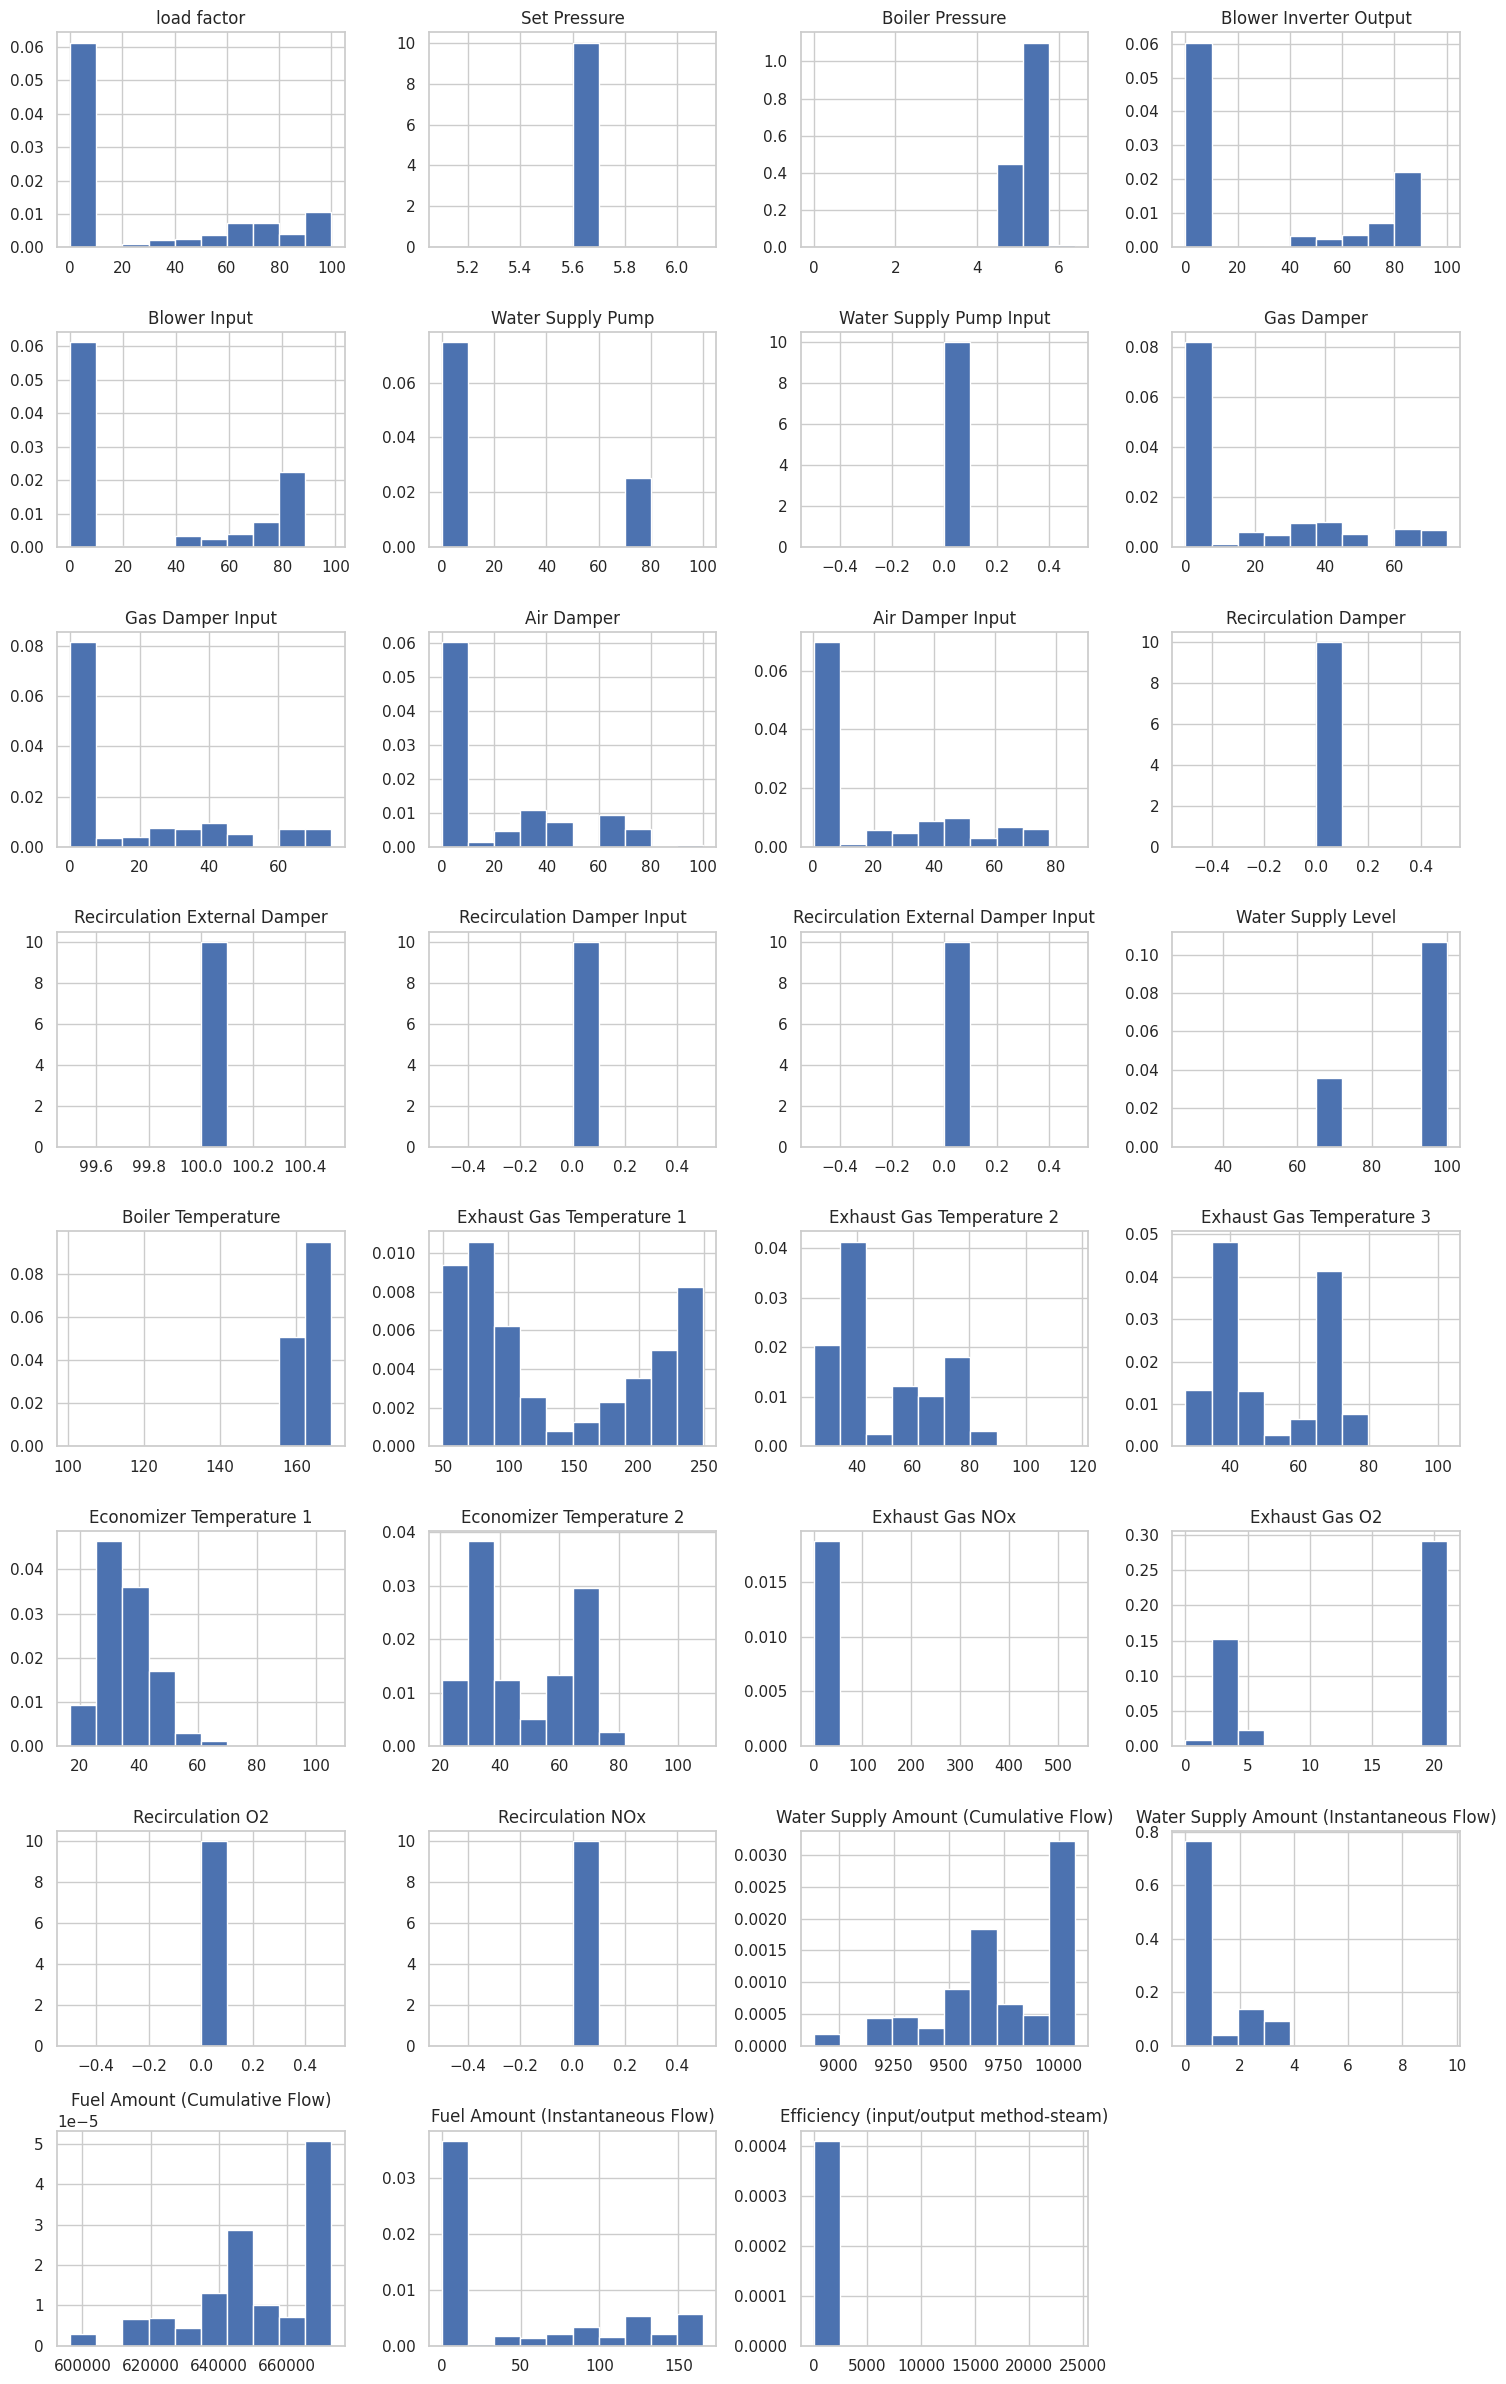

In [27]:
n_cols = len(combined_data.columns)
n_rows = (n_cols + 3) // 4  # 한 행에 4개씩 배치
fig = plt.figure(figsize=(15, 3*n_rows))

for i, col in enumerate(combined_data.columns, 1):
    plt.subplot(n_rows, 4, i)
    combined_data[col].hist(density=True)
    plt.title(col)

plt.tight_layout()
plt.show()

In [28]:
combined_data = combined_data[combined_data['load factor'] != 0]

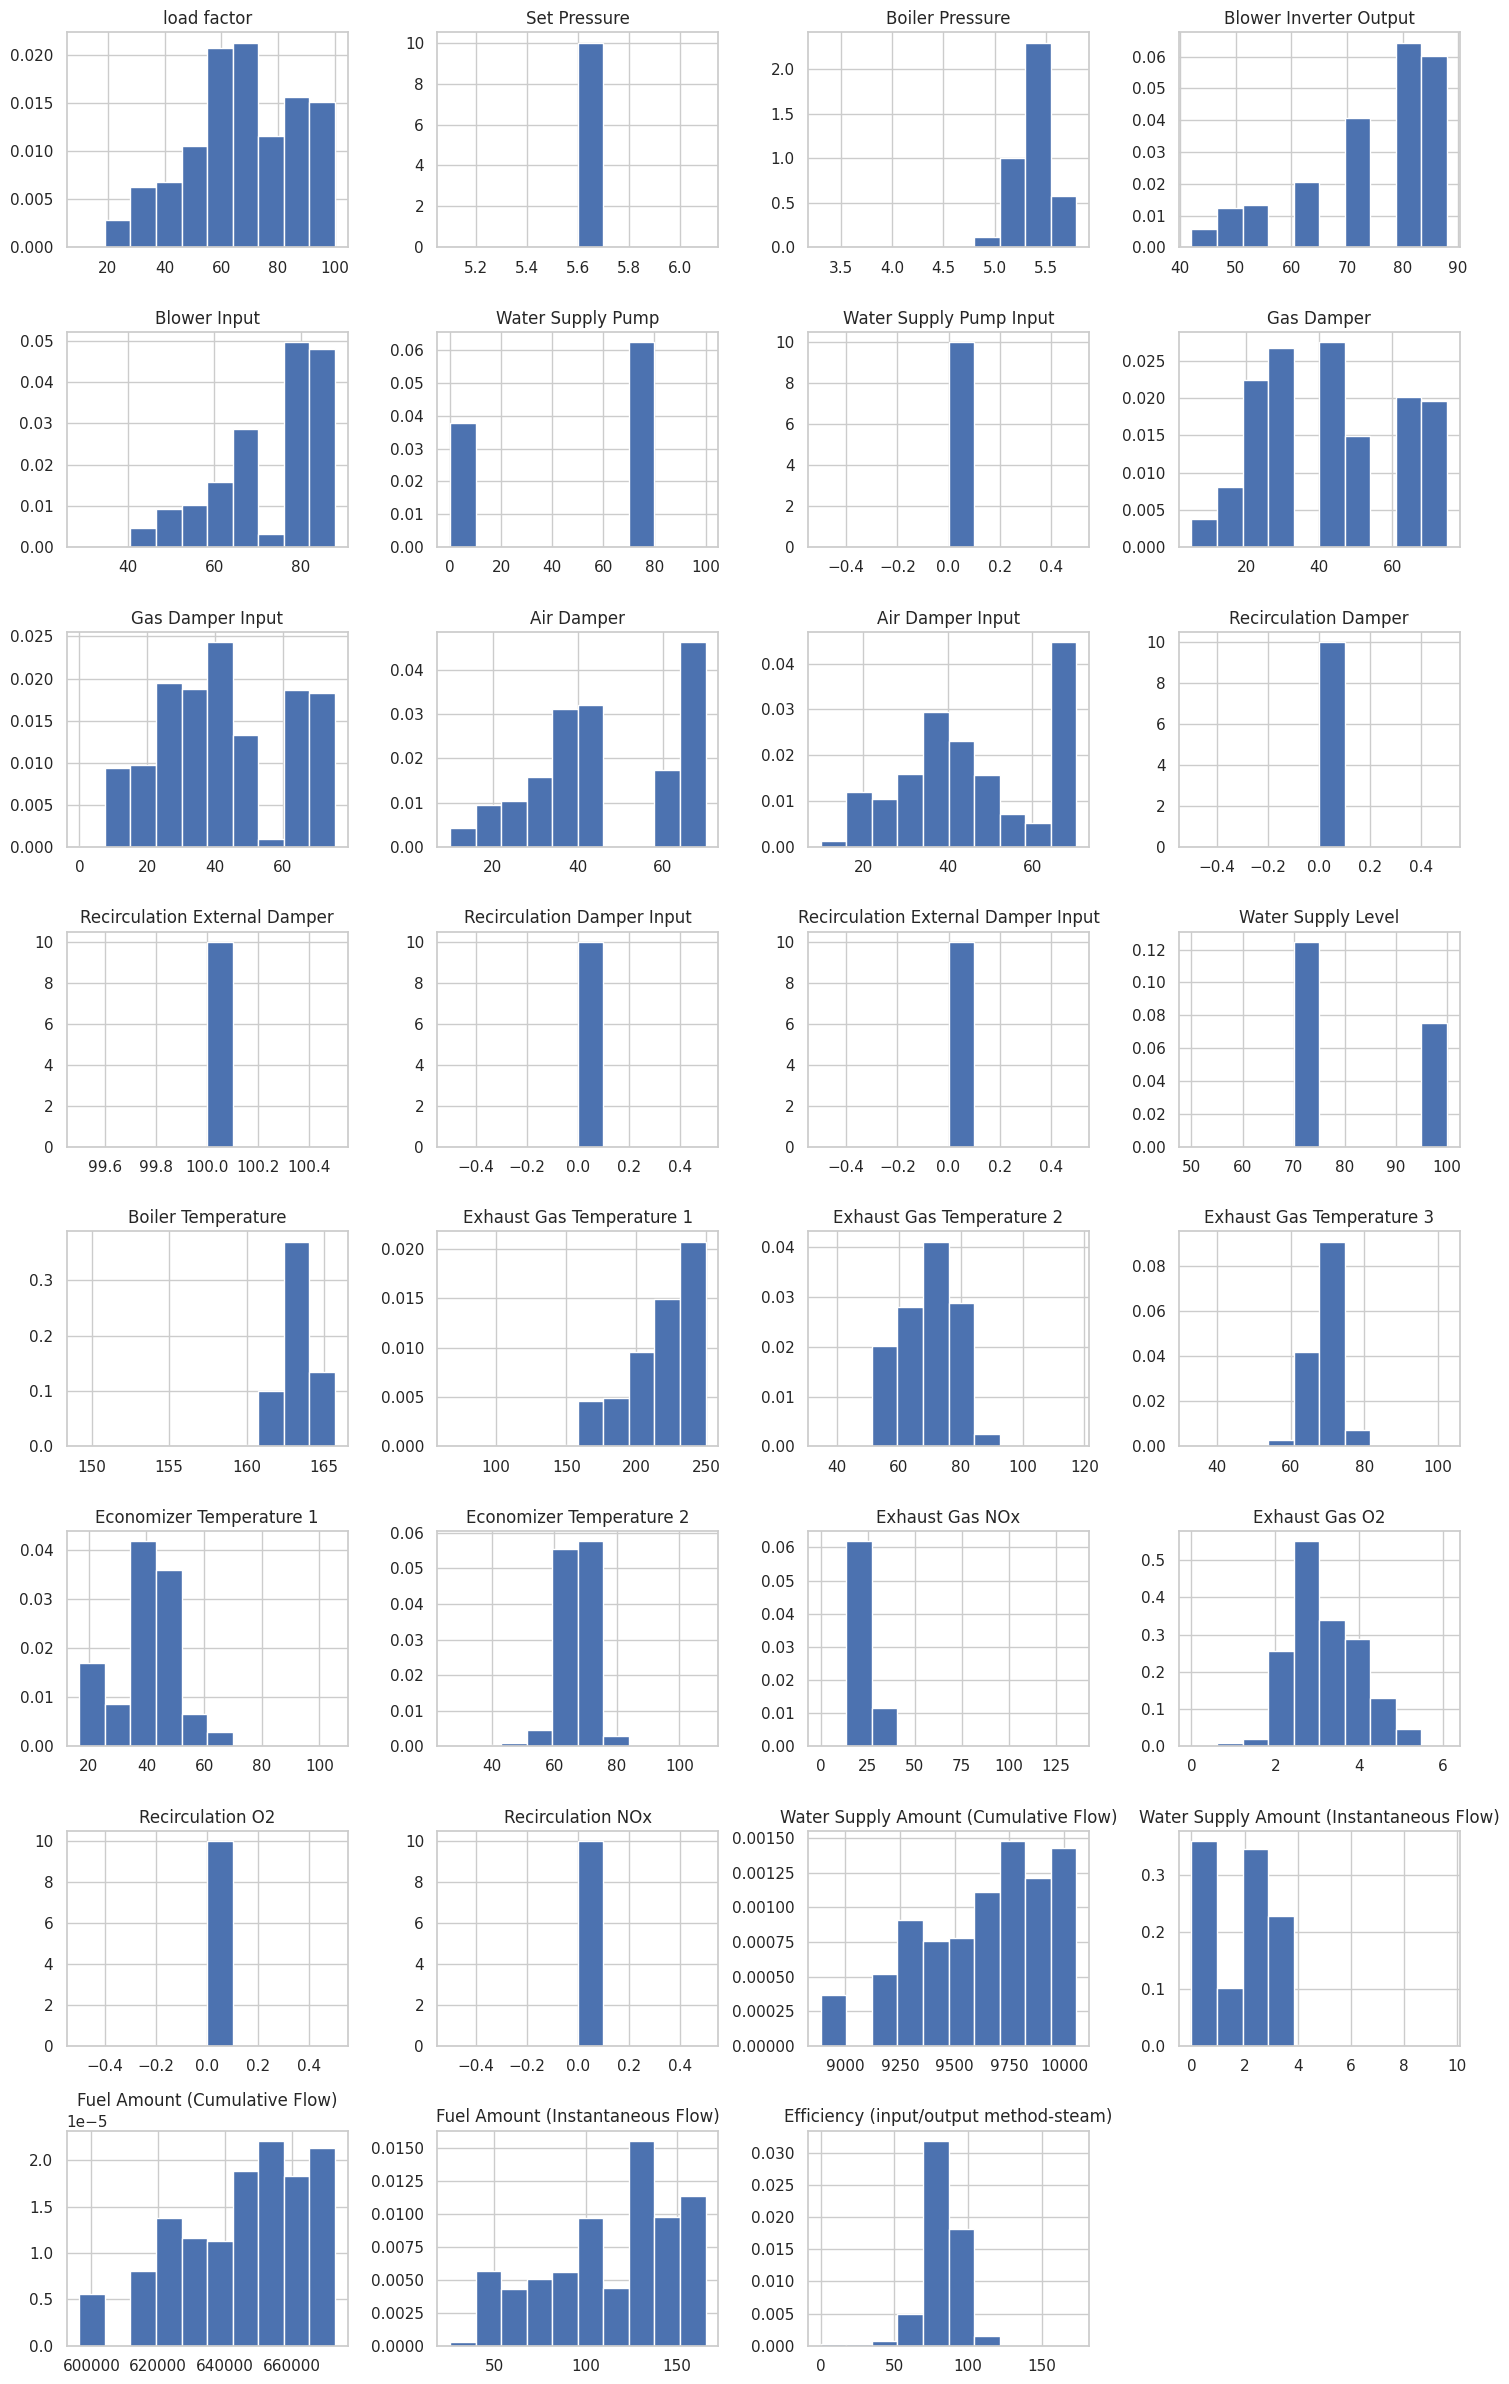

In [29]:
n_cols = len(combined_data.columns)
n_rows = (n_cols + 3) // 4  # 한 행에 4개씩 배치
fig = plt.figure(figsize=(15, 3*n_rows))

for i, col in enumerate(combined_data.columns, 1):
    plt.subplot(n_rows, 4, i)
    combined_data[col].hist(density=True)
    plt.title(col)

plt.tight_layout()
plt.show()

In [30]:
scaler = RobustScaler()
combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

## 중요도 추출 모델 (RF 모델)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)
combined_data = read_csv_file('/content/drive/MyDrive/preprocessed_boiler_data.csv')

# 독립 변수(X)와 종속 변수(y) 설정
X = combined_data.drop(columns=['Efficiency (input/output method-steam)'])  # 종속 변수 제외
y = combined_data['Efficiency (input/output method-steam)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
# rf = RandomForestRegressor(random_state=42,
#                            n_estimators=50,
#                            min_weight_fraction_leaf=0.0,
#                            min_samples_leaf=1,
#                            min_samples_split=5,
#                            max_features='sqrt',
#                            max_depth=25)

# rf.fit(X_train, y_train)

rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
    'min_samples_split': [2,5,10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
}

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
# print("Best hyperparameters found by RandomizedSearchCV:")
# print(random_search.best_params_)

# Model evaluation using test data
# y_pred = random_search.predict(X_test)
y_pred = random_search.predict(X_test)

# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAPE: inf
MAE: 0.2784
RMSE: 0.3896
MSE: 0.1518


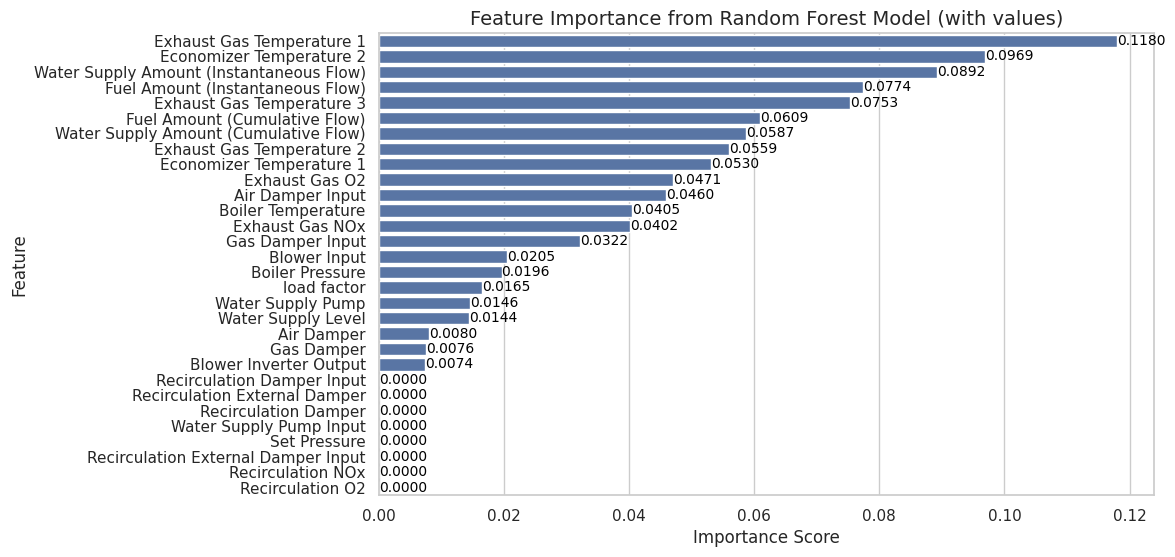

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import shutil

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# 예시 데이터 (random_search.best_estimator_는 미리 학습된 상태여야 함)
feature_importances = random_search.best_estimator_.feature_importances_
features = X.columns  # 각 피처의 이름

# 피처 중요도를 시리즈로 변환하고, 중요도 순서대로 정렬
feature_importance_series = pd.Series(feature_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importance_series, y=feature_importance_series.index)

# 각 바에 중요도 값을 텍스트로 표시
for i, (value, name) in enumerate(zip(feature_importance_series, feature_importance_series.index)):
    ax.text(value, i, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.title('Feature Importance from Random Forest Model (with values)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)

# 독립 변수(X)와 종속 변수(y) 설정
reduced_X = combined_data.loc[:, feature_importance_series.index[:16]]  # 종속 변수 제외
y = combined_data['Efficiency (input/output method-steam)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=42) # 예시: 80% 훈련, 20% 테스트

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
# reduced_rf = RandomForestRegressor(random_state=42,
#                                    n_estimators=200,
#                                    min_weight_fraction_leaf=0.0,
#                                    min_samples_split=2,
#                                    min_samples_leaf=4,
#                                    max_features='sqrt',
#                                    max_depth=20)

reduced_rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [25, 50, 100, 150, 200],      # Number of trees
    'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
    'min_samples_split': [2,5,10,15],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
}

# # Randomized Search CV with 5-fold cross-validation
reduced_random_search = RandomizedSearchCV(estimator=reduced_rf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
reduced_random_search.fit(X_train, y_train)

# # Best parameters
print("Best hyperparameters found by RandomizedSearchCV:")
print(reduced_random_search.best_params_)

# Model evaluation using test data
y_pred = reduced_random_search.predict(X_test)
# y_pred = reduced_rf.fit(X_train, y_train).predict(X_test)


# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
MAPE: inf
MAE: 0.2691
RMSE: 0.3813
MSE: 0.1454


## 최적화 모델

In [34]:
from scipy.optimize import differential_evolution

# 목적 함수 정의
def objective_function(x):
    pred = reduced_random_search.best_estimator_.predict(pd.DataFrame(x.reshape(1,-1), columns=X_train.columns))
    return -pred[0]  # maximize efficiency by minimizing the negative

# 파라미터 범위 정의 (예: 각 파라미터 값의 범위)
bounds = [(combined_data[col].min(), combined_data[col].max()) for col in X_train.columns]  # 각 변수의 최소/최대값에 따라 조정

# Differential Evolution 최적화 실행
result = differential_evolution(objective_function, bounds)
print("Optimal x:", result.x)
print("Optimal efficiency:", -result.fun)

Optimal x: [ 0.138113   -1.18092627 -0.74505252 -0.49708726 -0.58543468  0.67577448
  0.66264919 -0.66193269 -1.95871605  0.6693284  -0.19912671 -0.08809421
 -0.47259773  0.16234278  0.22150489 -8.99873106]
Optimal efficiency: 3.0504124581991032


## 전처리 원상복구

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 최적화된 상태의 데이터
optimized_data = pd.DataFrame(columns=combined_data.columns)
optimized_data.loc[0] = [0 for _ in range(len(combined_data.columns))]

for i, col in enumerate(features[:16]):
  if optimized_data.dtypes[i] == 'int64':
    optimized_data.loc[0, col] = int(result.x[i])
  else:
     optimized_data.loc[0, col] = result.x[i]
optimized_data['Efficiency (input/output method-steam)'] = -result.fun


# 데이터 스케일링 및 레이블 인코딩

# 1. 역 스케일링 (StandardScaler를 사용한 스케일링 복구)
# 숫자형 열에 대해 StandardScaler로 스케일링된 값을 원래 값으로 복구
optimized_data[numeric_columns] = scaler.inverse_transform(optimized_data[numeric_columns][numeric_columns].values)


#복구된 데이터 확인
print(optimized_data.head())

   load factor  Set Pressure  Boiler Pressure  Blower Inverter Output  \
0         70.0           4.6              5.3                    81.0   

   Blower Input  Water Supply Pump  Water Supply Pump Input  Gas Damper  \
0          79.4               75.0                      0.0        40.0   

   Gas Damper Input  Air Damper  ...  Economizer Temperature 2  \
0               5.9        45.0  ...                      67.4   

   Exhaust Gas NOx  Exhaust Gas O2  Recirculation O2  Recirculation NOx  \
0             25.0             3.0               0.0                0.0   

   Water Supply Amount (Cumulative Flow)  \
0                                9690.21   

   Water Supply Amount (Instantaneous Flow)  Fuel Amount (Cumulative Flow)  \
0                                       2.1                       648535.0   

   Fuel Amount (Instantaneous Flow)  Efficiency (input/output method-steam)  
0                             124.2                              122.163767  

[1 rows x 31 co

<ipython-input-35-85d083952371>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-35-85d083952371>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-35-85d083952371>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-35-85d083952371>:11: FutureWarning: Series.__getitem__ 

In [39]:
combined_data = scaler.inverse_transform(combined_data[numeric_columns])

In [40]:
combined_data['Efficiency (input/output method-steam)'].plot(kind='box', showfliers=False)
plt.plot(1, 95.341617, 'ro', label='Optimal Value')
plt.ylabel('Efficiency')
plt.title('Boxplot of Efficiency')

plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices